# **CIS 5450 Final Project - Apartment Rental Price Prediction**
*Nathan Aronson, Savir Basil, Khoi Dinh*

# Part 1: Introduction

In our final project, we wanted to explore the main indicators of apartment rental price listings across the United States in the year 2023. The dataset, `apartments_df` contains aggregated listings across the nation, including the rental price, geographical location, square footage, and other amenities for various apartment listings. Through the dataset and its features, we have been able to develop a strong understanding of what factors drive listing price.

Such results are below. We contain in-depth explanations of our rationale behind each action, takeaways, and analyses of how these features explain one another.

We hope you enjoy.

# Part 2: Data Loading & Preprocessing

Much of our notebook involves custom Python library functions. To that end, we must import these fundamental components, namely pandas, sklearn, numpy, and matplotlib.

In [ ]:
# Imports + Installs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim

## 2.1 Loading + Preprocessing Apartment Data

Although originally available on Kaggle, we decided to host our dataset on GitHub for convenience, and in the event Kaggle is down.

The features of the table are semicolon separated, while the file is encoded in Windows-1252.

In [ ]:
# Data loading via GitHub
github_url = "https://media.githubusercontent.com/media/nathanaronson/Apartment-Fair-Rental-Prediction/refs/heads/main/data/apartment_data.csv"
apartments_df = pd.read_csv(github_url, sep=';', encoding='cp1252')

## 2.2 Analyzing Data Structure

In [ ]:
# Setting to display all features
pd.set_option('display.max_columns', None)
apartments_df.head()

id                category                            title  \
0  5668640009  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  5668639818  housing/rent/apartment      Three BR 146 Lochview Drive   
2  5668639686  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  5668639659  housing/rent/apartment            Two BR 209 Aegean Way   
4  5668639374  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities  bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...       NaN        1.0   
1  This unit is located at 146 Lochview Drive, Ne...       NaN        1.5   
2  This unit is located at 3101 Morningside Drive...       NaN        2.0   
3  This unit is located at 209 Aegean Way, Vacavi...       NaN        1.0   
4  This unit is located at 4805 Marquette NE, Alb...       NaN        1.0   

   bedrooms currency fee  has_photo pets_allowed   price price_display  \
0       1.0      USD  No  Thumbnail         Cats  2195.0        $2,195   
1       3.0      USD  No  Thumbnail    Cats,Dogs  1250.0        $1,250   
2       3.0      USD  No  Thumbnail          NaN  1395.0        $1,395   
3       2.0      USD  No  Thumbnail    Cats,Dogs  1600.0        $1,600   
4       1.0      USD  No  Thumbnail    Cats,Dogs   975.0          $975   

  price_type  square_feet              address       cityname state  latitude  \
0    Monthly          542   507  509 Esplanade  Redondo Beach    CA   33.8520   
1    Monthly         1500      146 Lochview Dr   Newport News    VA   37.0867   
2    Monthly         1650  3101 Morningside Dr        Raleigh    NC   35.8230   
3    Monthly          820       209 Aegean Way      Vacaville    CA   38.3622   
4    Monthly          624    4805 Marquette NE    Albuquerque    NM   35.1038   

   longitude     source        time  
0  -118.3759  RentLingo  1577360355  
1   -76.4941  RentLingo  1577360340  
2   -78.6438  RentLingo  1577360332  
3  -121.9712  RentLingo  1577360330  
4  -106.6110  RentLingo  1577360308

In [ ]:
# Dataframe info
apartments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99492 non-null  int64  
 1   category       99492 non-null  object 
 2   title          99492 non-null  object 
 3   body           99492 non-null  object 
 4   amenities      83448 non-null  object 
 5   bathrooms      99429 non-null  float64
 6   bedrooms       99368 non-null  float64
 7   currency       99492 non-null  object 
 8   fee            99492 non-null  object 
 9   has_photo      99492 non-null  object 
 10  pets_allowed   39068 non-null  object 
 11  price          99491 non-null  float64
 12  price_display  99491 non-null  object 
 13  price_type     99492 non-null  object 
 14  square_feet    99492 non-null  int64  
 15  address        7943 non-null   object 
 16  cityname       99190 non-null  object 
 17  state          99190 non-null  object 
 18  latitu

In [ ]:
# Dataframe column datatypes
apartments_df.dtypes

id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
has_photo         object
pets_allowed      object
price            float64
price_display     object
price_type        object
square_feet        int64
address           object
cityname          object
state             object
latitude         float64
longitude        float64
source            object
time               int64
dtype: object

To get a more-specific understanding of our data, we would like to calculate some measures, namely its distribution, to help guide us in removing outliers, normalizing our data, and engineering valuable featues.

In [ ]:
# Dataframe numerical statistics
apartments_df.describe()

id     bathrooms      bedrooms         price   square_feet  \
count  9.949200e+04  99429.000000  99368.000000  99491.000000  99492.000000   
mean   5.358321e+09      1.445323      1.728212   1527.057281    956.430688   
std    1.847404e+08      0.547021      0.749200    904.245882    417.571522   
min    5.121046e+09      1.000000      0.000000    100.000000    101.000000   
25%    5.197950e+09      1.000000      1.000000   1013.000000    729.000000   
50%    5.508673e+09      1.000000      2.000000   1350.000000    900.000000   
75%    5.509007e+09      2.000000      2.000000   1795.000000   1115.000000   
max    5.669439e+09      9.000000      9.000000  52500.000000  50000.000000   

           latitude     longitude          time  
count  99467.000000  99467.000000  9.949200e+04  
mean      36.947988    -91.568656  1.559665e+09  
std        4.599461     15.817168  1.105077e+07  
min       19.573800   -159.369800  1.544174e+09  
25%       33.746500   -104.791900  1.550832e+09  
50%       37.228200    -84.562300  1.568745e+09  
75%       39.953000    -77.608200  1.568767e+09  
max       64.833200    -68.778800  1.577391e+09

These results indicated a few noticeable takeaways, namely that we are likely to see outliers in the number of bedrooms, bathrooms, and price. Moreover, these outliers are likely to be correlated with one another. Nonetheless, we will perform data analysis to remove such outliers and clean our data. Lastly, we are going to justify the following data manipulations:


*  The `id` column will be dropped as it yields no valuable information
*  The `price` column should be dependent on monthly `price_display` for time consistency
*  This dataset allows for half bedrooms/bathrooms, and thus these columns will have their floating-point values floored

We will then assess the veracity of this data in the EDA section.

In [ ]:
# Dataframe categorical statistics
apartments_df.describe(include='object')

category                        title  \
count                    99492                        99492   
unique                       7                        58503   
top     housing/rent/apartment  Apartment in great location   
freq                     99431                         1064   

                                                     body amenities currency  \
count                                               99492     83448    99492   
unique                                              94503      9827        1   
top     When searching for a pet-friendly One-, Two- a...   Parking      USD   
freq                                                   43      6188    99492   

          fee has_photo pets_allowed price_display price_type  \
count   99492     99492        39068         99491      99492   
unique      2         3            4          3718          3   
top        No       Yes    Cats,Dogs        $1,350    Monthly   
freq    99291     55974        37097           574      99488   

                     address cityname  state        source  
count                   7943    99190  99190         99492  
unique                  7771     2979     51            25  
top     8215 S.W 72nd Avenue   Dallas     TX  RentDigs.com  
freq                      19     2858  11257         90912

Before we make assumptions about what categorical columns to drop, let's evaluate the completeness of our data.

In [ ]:
# Compute missing values
apartments_df.isnull().sum()

id                   0
category             0
title                0
body                 0
amenities        16044
bathrooms           63
bedrooms           124
currency             0
fee                  0
has_photo            0
pets_allowed     60424
price                1
price_display        1
price_type           0
square_feet          0
address          91549
cityname           302
state              302
latitude            25
longitude           25
source               0
time                 0
dtype: int64

However, to determine completeness, it would make more sense to see what percentage of each column has values.

In [ ]:
# Compute missing value percentages
(apartments_df.isnull().sum() / len(apartments_df)) * 100

id                0.000000
category          0.000000
title             0.000000
body              0.000000
amenities        16.125920
bathrooms         0.063322
bedrooms          0.124633
currency          0.000000
fee               0.000000
has_photo         0.000000
pets_allowed     60.732521
price             0.001005
price_display     0.001005
price_type        0.000000
square_feet       0.000000
address          92.016444
cityname          0.303542
state             0.303542
latitude          0.025128
longitude         0.025128
source            0.000000
time              0.000000
dtype: float64

Takeaways:

*  Suprisingly, most of the `address` entries are null. We are likely to drop these as inferring them based on geographic location is totally acceptable.
*  `pets_allowed` also contains a lot of null entries. However, this is valuable information as a null entry likely means that no pets are allowed. Therefore, we will not be dropping these entries. Same with `ameneties`.
*  Therefore, `amenities` and `pets_allowed` can have their missing values filled with a specific keyword
*  Columns `bedrooms` and `bathrooms` can have their missing values filled with medians to prevent artifical skewing
*  The remaining values that are missing should have their respective rows removed
*  The `price` column yields the `price_display` column intert, and will be dropped, same with `price_type`
*  `category` will also be dropped, as well as `title`, `body`, and `currency` for lack of data value
*  The `source` column should be dropped due to other factors.

## 2.3 Dropping Insignificant Rows + Null Rows

Dropping `id`: We dropping this column due to its lack of value in our price analysis/classification.

In [ ]:
# Dropping id column
apartments_df = apartments_df.drop(columns=['id'], axis=1)

Dropping `category`: Same reasoning as above.

In [ ]:
# Dropping category column
apartments_df = apartments_df.drop(columns=['category'], axis=1)

Dropping `title`: We dropped this column due its lack of value in our price analysis/classification. It may contain useful indicators like whether it is a luxury apartment, etc., but that can be acquired through other features in a given row.

In [ ]:
# Dropping title column
apartments_df = apartments_df.drop(columns=['title'], axis=1)

Dropping `body`: Same reasoning as above.

In [ ]:
# Dropping body column
apartments_df = apartments_df.drop(columns=['body'], axis=1)

Dropping `currency`: Based on our analysis, we see that every currency is in USD, therefore is not a useful predictor.

In [ ]:
# Dropping currency
apartments_df = apartments_df.drop(columns=['currency'], axis=1)

Dropping `price_display`: The `price` column already has this information cleaned.

In [ ]:
# Dropping price display
apartments_df = apartments_df.drop(columns=['price_display'], axis=1)

Dropping `price_type`: Same reasoning as above.

In [ ]:
# Dropping price type
apartments_df = apartments_df.drop(columns=['price_type'], axis=1)

Dropping `address`: The vast majority of entries are empty. Moreover, we can get a better estimate of address through the latitude/longitude.

In [ ]:
# Dropping address
apartments_df = apartments_df.drop(columns=['address'], axis=1)

Dropping `source`: In order to accurately determine the value of the `source`, we would need more features to holistically approach this. As such, we will eliminate it from our consideration in how it weights values such as price prediction.

In [ ]:
# Dropping source
apartments_df = apartments_df.drop(columns=['source'], axis=1)

## 2.4 Filling in Missing Values and Increasing Normalization

We will then need to clean the data, filling in missing values and dropping others.

In [ ]:
# Filling missing categorical values
apartments_df['amenities'] = apartments_df['amenities'].fillna('Missing')
apartments_df['pets_allowed'] = apartments_df['pets_allowed'].fillna('Missing')

Rather than dropping rows that don't have the number of bedrooms or bathrooms listed, we will instead fill their entries with the median to prevent skewing. We admit that this may result in potential artificial generation, such as an apartment that has a very high listing that would have a lot of bedrooms be listed as a much lower amount. Therefore, we need to remove outliers to eliminate this skewing.

In [ ]:
# Median replacement
apartments_df['bedrooms'] = apartments_df['bedrooms'].fillna(apartments_df['bedrooms'].median())
apartments_df['bathrooms'] = apartments_df['bathrooms'].fillna(apartments_df['bathrooms'].median())

We will then drop any other rows that have null values due to the difficulty of engineering replacements for such.

In [ ]:
# Drop nulls
apartments_df = apartments_df.dropna()

Next, we will split up the `amenities` and `price_allowed` columns into their individual components to better assess their influences on prediction. We can then use one-hot encoding on these categorical variables to enable their predictiveness.

In [ ]:
# Separate values into new columns
apartments_df = pd.concat([apartments_df, apartments_df['amenities'].str.get_dummies(sep=',').add_prefix('amenities_')], axis=1)
apartments_df = pd.concat([apartments_df, apartments_df['pets_allowed'].str.get_dummies(sep=',').add_prefix('pets_allowed_')], axis=1)

# Drop original columns
apartments_df.drop(columns=["amenities", "pets_allowed"], inplace=True)

Now that our data is filtered, we want to consider edge cases or outliers that would complicate or skew our analysis. We identified scenarios relating to two features:

*   Regarding `bathrooms`: certain apartments might have a shared hallway bathrooms while others could have as much as nine. Therefore, it would logically make sense to maintain within the middle 50% of data to guarantee that those apartments are likely to yield similar economic conditions: personal bathrooms and non-luxurious disproportionate apartments. This will target a pruend, normal distribution
*   Regarding `bedrooms`: similar reasoning to above where having zero bedrooms makes no sense as you would never want to live there, while nine bedrooms would be considered a luxury apartment.
*   Regarding `price`: there are multiple factors contributing to price, meaning that one lister might unfairly list their apartment price incredibly high due to brand reputation or other factors. As such, keeping within 1.5 times the IQR would make sense to prevent such deviations.
*   Regarding `square_feet`: keeping within 1.5 times the IQR would prevent the analysis of shoebox apartments versus effectively mansion condominiums. Therefore, this would eliminate such apartments.

In other words, keeping within 1.5 times the IQR eliminates non-predictable factors such as renter influence, or the non-uniform properties of apartments as they deviate from the norm, namely shoebox apartments versus luxury.

In [ ]:
# Features to be pruned
numerical_cols = ['bathrooms', 'bedrooms', 'price', 'square_feet']

# Original number of rows
initial_count = len(apartments_df)

# Calculate the lower quartile
Q1 = apartments_df[numerical_cols].quantile(0.25)

# Calculate the upper quartile
Q3 = apartments_df[numerical_cols].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Set ranges
lower_quantile_range = Q1 - 1.5 * IQR
upper_quantile_range = Q3 + 1.5 * IQR

# Remove rows whose values are outside of ranges
apartments_df = apartments_df[~((apartments_df[numerical_cols] < lower_quantile_range) | (apartments_df[numerical_cols] > upper_quantile_range)).any(axis=1)]

# Compute results
print(f"Entries Removed: {initial_count - len(apartments_df)}\n")
print(f"Upper Quantile Range of Features:\n{upper_quantile_range}\n")
print(f"Lower Quantile Range of Features:\n{lower_quantile_range}")

Entries Removed: 7213

Upper Quantile Range of Features:
bathrooms         3.5
bedrooms          3.5
price          2969.5
square_feet    1694.0
dtype: float64

Lower Quantile Range of Features:
bathrooms       -0.5
bedrooms        -0.5
price         -162.5
square_feet    150.0
dtype: float64


Lastly, we will convert all `bathrooms` and `bedrooms` to integers.

*  We discovered that flooring produces less data variance than ceiling
*  Pragmatically, the net increase in value of half bathroom is going to be closer to no bathroom than full bathroom, as that space could be used for a more ideal purpose.
*  A half bedroom doesn't exist. There is no discrepancy with such, either there is a bed and you sleep there or you do not.

In [ ]:
# Convert to integers
apartments_df['bathrooms'] = apartments_df['bathrooms'].astype('int')
apartments_df['bedrooms'] = apartments_df['bedrooms'].astype('int')

In [ ]:
# Get dimensions of dataframe
apartments_df.shape

(91976, 43)

In [ ]:
# See cleaned dataframe
apartments_df.head()

bathrooms  bedrooms fee  has_photo   price  square_feet       cityname  \
0          1         1  No  Thumbnail  2195.0          542  Redondo Beach   
1          1         3  No  Thumbnail  1250.0         1500   Newport News   
2          2         3  No  Thumbnail  1395.0         1650        Raleigh   
3          1         2  No  Thumbnail  1600.0          820      Vacaville   
4          1         1  No  Thumbnail   975.0          624    Albuquerque   

  state  latitude  longitude        time  amenities_AC  amenities_Alarm  \
0    CA   33.8520  -118.3759  1577360355             0                0   
1    VA   37.0867   -76.4941  1577360340             0                0   
2    NC   35.8230   -78.6438  1577360332             0                0   
3    CA   38.3622  -121.9712  1577360330             0                0   
4    NM   35.1038  -106.6110  1577360308             0                0   

   amenities_Basketball  amenities_Cable or Satellite  amenities_Clubhouse  \
0                     0                             0                    0   
1                     0                             0                    0   
2                     0                             0                    0   
3                     0                             0                    0   
4                     0                             0                    0   

   amenities_Dishwasher  amenities_Doorman  amenities_Elevator  \
0                     0                  0                   0   
1                     0                  0                   0   
2                     0                  0                   0   
3                     0                  0                   0   
4                     0                  0                   0   

   amenities_Fireplace  amenities_Garbage Disposal  amenities_Gated  \
0                    0                           0                0   
1                    0                           0                0   
2                    0                           0                0   
3                    0                           0                0   
4                    0                           0                0   

   amenities_Golf  amenities_Gym  amenities_Hot Tub  \
0               0              0                  0   
1               0              0                  0   
2               0              0                  0   
3               0              0                  0   
4               0              0                  0   

   amenities_Internet Access  amenities_Luxury  amenities_Missing  \
0                          0                 0                  1   
1                          0                 0                  1   
2                          0                 0                  1   
3                          0                 0                  1   
4                          0                 0                  1   

   amenities_Parking  amenities_Patio/Deck  amenities_Playground  \
0                  0                     0                     0   
1                  0                     0                     0   
2                  0                     0                     0   
3                  0                     0                     0   
4                  0                     0                     0   

   amenities_Pool  amenities_Refrigerator  amenities_Storage  amenities_TV  \
0               0                       0                  0             0   
1               0                       0                  0             0   
2               0                       0                  0             0   
3               0                       0                  0             0   
4               0                       0                  0             0   

   amenities_Tennis  amenities_View  amenities_Washer Dryer  \
0                 0               0                       0   
1                 0               0           

# Part 3: Exploratory Data Analysis

Now that we understand the general gist of our data and discovered its summary statistics, we would like to further evaluate the relationships between meaningful features. While we could have made an infinite number of graphs, we believe the selection we chose most accurately depicted the important relationships that would ultimately guide us in understanding our models' performances.

### 3.1 Distribution Evaluation

#### 3.1.1 Price Evaluation

To begin, we chose to visualize the number of apartment numerical quantities across the nation as a histogram. This allows us to visualize the distribution and potentially distinguish outliers or determine overall skew. We already performed IQR pruning so we expect there to be no massive outliers.

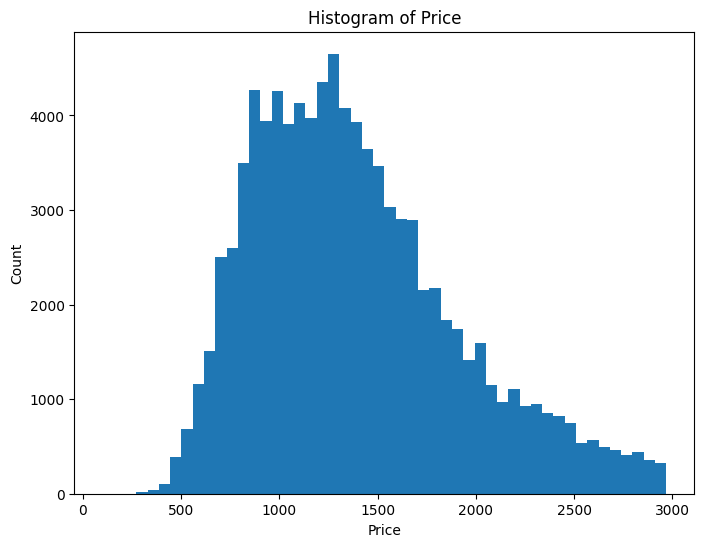

In [ ]:
# Set plot dimensions
plt.figure(figsize=(8,6))

# Create histogram
plt.hist(apartments_df['price'], bins=50)

# Set title and axes
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Count')

# Show graph
plt.show()

Takeaways:

*  The distribution is relatively normal, unimodal, with a slight skew to the right.
*  The slight skew to the right can be explained by the greater range of possible listings in increased value, that is, the smallest possible price listing is 0 while the greatest possible price listing could be in the thousands.
*  We do see a cut-off on the right-hand side, however this pruning is negligible as such values are likely to be unpredictable due to the nature of renters, and not the amount of bathrooms or bedrooms among others.

#### 3.1.2 Square Feet Evaluation

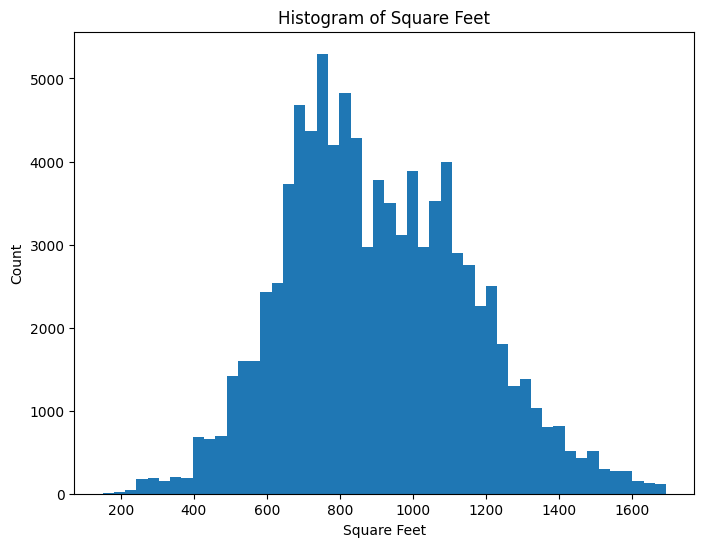

In [ ]:
# Set plot dimensions
plt.figure(figsize=(8,6))

# Create histogram
plt.hist(apartments_df['square_feet'], bins=50)

# Set title and axes
plt.title('Histogram of Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Count')

# Show graph
plt.show()

Takeaways:

*  The distribution is relatively normal, unimodal, with a slight skew to the right.
*  We can see a clear step-down left-hand distribution, likely due to the normalization of apartment sizes. That is, there are a lot of apartments that have a set size.
*  Based on the fact that the price and square feet are now normal, we need to determine how the two are correlated.

#### 3.1.3 Price per Square Feet Evaluation

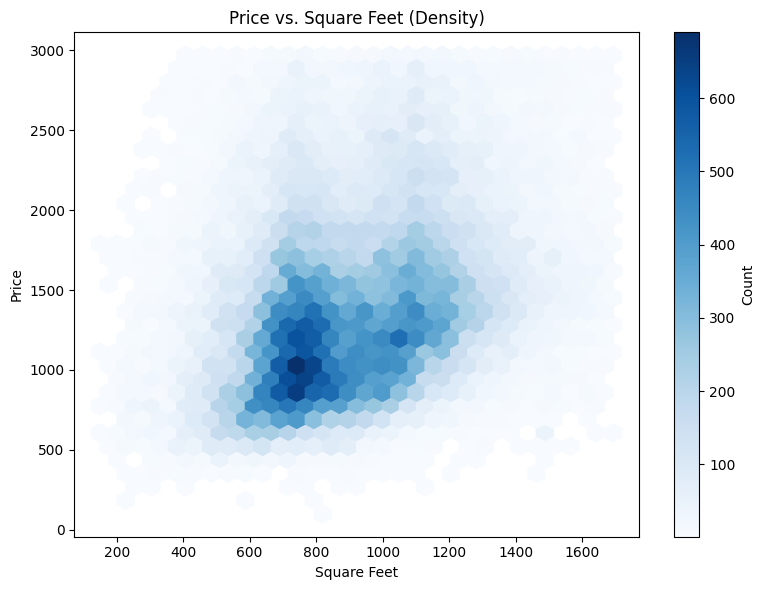

In [ ]:
# Set dimensions
plt.figure(figsize=(8, 6))

# Create hexbin
plt.hexbin(x=apartments_df['square_feet'], y=apartments_df['price'], gridsize=30, cmap='Blues', mincnt=1)

# Assign color legend
plt.colorbar(label='Count')

# Set title and axes
plt.title("Price vs. Square Feet (Density)")
plt.xlabel("Square Feet")
plt.ylabel("Price")

# Adjusts padding
plt.tight_layout()

# Show graph
plt.show()

Takeaways:

*   Unsurprisingly, there is a cluster of values that appear in high density. This appears around the peaks of clusters for both datasets.
*   We see a slight upwards-to-the-right trend of density occurring, which would be consistent with the fact that price increases with the size.
*   Interestingly, the correlation between price and square feet isn't as strong as we'd expected. This must mean that price is influenced by other factors, which we will explore.

## 3.2 Geographic Evaluation

We now knew that our data was normalized, that is, the distribution of our numerical values were normal. However, the entire dataset was sampled from the entire United States, yet we would like to explore the distribution of these states.

### 3.2.1 Heatmap of Listings

We started off by producing a heatmap revealing the distributions of listings.

In [ ]:
# Create a base map centered on the continental US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Create a list of [latitude, longitude, weight] where weight = price
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in apartments_df.iterrows()]

# Add the HeatMap layer
HeatMap(
    heat_data,
    min_opacity=0.2,
    max_opacity=0.9,
    radius=15,       # Radius of each point's influence
    blur=10,         # Amount of blur
    max_val=max(apartments_df['price']),  # Helps normalize color scaling
).add_to(m)

# Display the map
m

<ipython-input-270-7276535e3f30>:8: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.



Takeaways:

*  There are large heat areas clustered around cities, in particular Los Angeles and Washington DC.
*  The Northeast Megalopolis and Mid-West seem to have the highest density of listings
*  The eastern portion of the West area and the northern portion of the Mountain area have few listings. This makes sense as these areas are sparsely populated due to the Rocky Mountains.

### 3.2.2 Scattermap of Price Listings

In [ ]:
# Create scattermap
fig = px.scatter_mapbox(
    apartments_df,
    lat='latitude',
    lon='longitude',
    color='price',
    hover_name='price',
    mapbox_style='carto-darkmatter',
    zoom=3,
    height=600
)

# Show graph
fig.show()

Takeaways:

*  Both the West Coast and East Coast have higher price listings on average than the middle of the United States.
*  Cities tend to have higher price listings and higher density of listings than other areas.
*  There is a gradient effect happening where prices increase towards some center and decrease in price away from such center.
*  Latitude is likely to play a more important role than longitude.

### 3.2.3 States by Average Rental Price

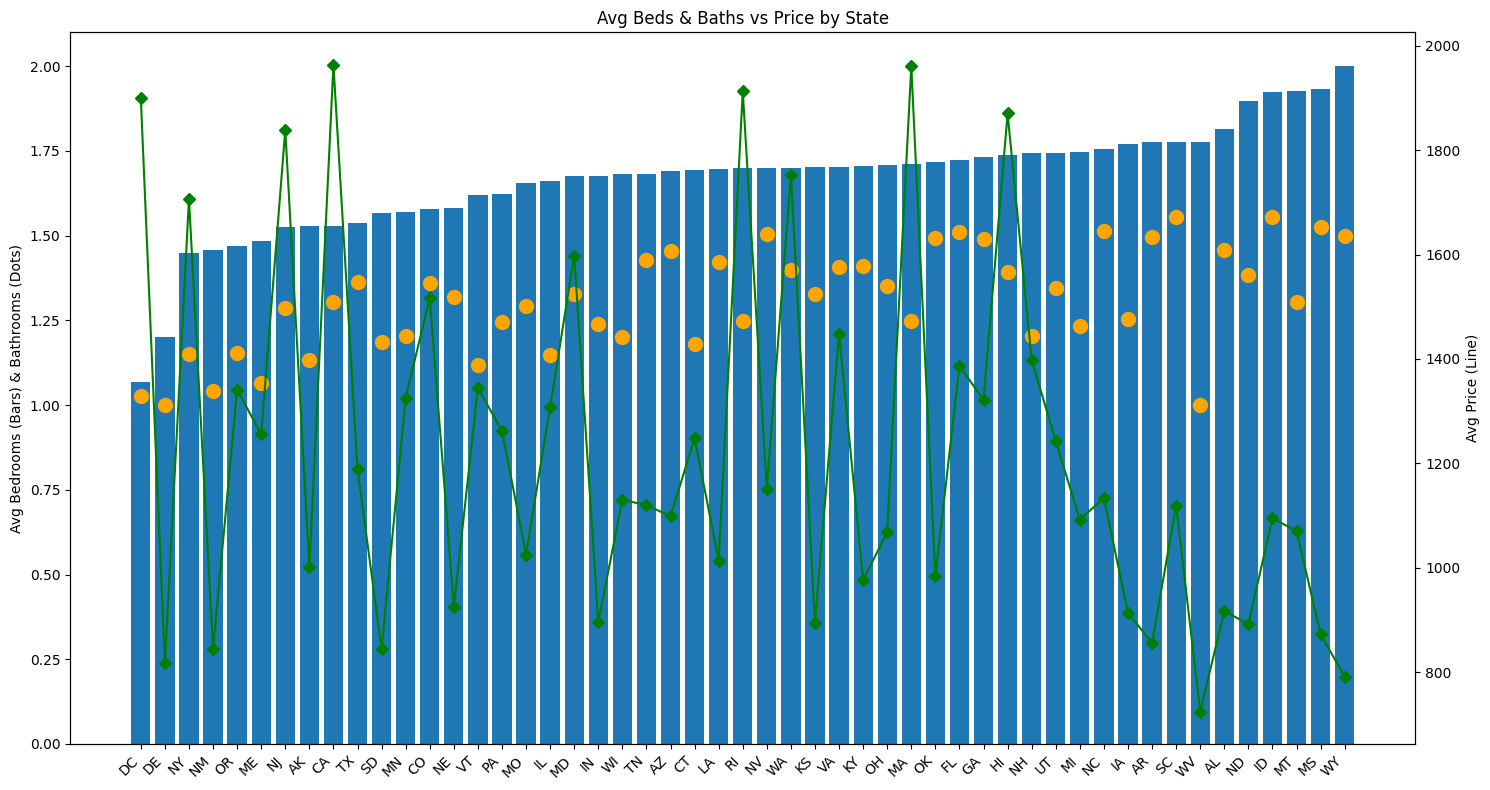

In [ ]:
# Aggregate the number of bedrooms, bathrooms, and price of each state to compute mean
agg = (apartments_df
       .groupby('state')
       .agg(bedrooms=('bedrooms','mean'),
            bathrooms=('bathrooms','mean'),
            price=('price','mean'))
       .sort_values('bedrooms', ascending=True))

# Create array
x = np.arange(len(agg))

# Set up twin axes
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

# Set the bars to be the number of bedrooms
ax1.bar(x, agg['bedrooms'], label='Avg Bedrooms')

# Set the dots to be the number of bathrooms
ax1.scatter(x, agg['bathrooms'], color='orange', s=100, label='Avg Bathrooms')

# Assign labels for axes
ax1.set_ylabel('Avg Bedrooms (Bars) & Bathrooms (Dots)')
ax2.set_ylabel('Avg Price (Line)')
ax1.set_xticks(x)
ax1.set_xticklabels(agg.index, rotation=45, ha='right')

# Plot the graph
ax2.plot(x, agg['price'], color='green', marker='D', label='Avg Price')

# Set the title
plt.title('Avg Beds & Baths vs Price by State')

# Correct the padding
plt.tight_layout()

# Show graph
plt.show()

Takeaways:

*  There is a slight trend between increasing the number of bathrooms and the number of bathrooms. This makes sense as more people often involves more of both.
*  States with large cities have way higher average prices than more rural states. This makes sense as these cities have not only more apartments, but higher demand for apartments and thus higher prices.
*  There is no strong visual correlation between the average price and the number of bathrooms or bedrooms.

## 3.3 Correlation Evaluation

Now that we have determined whether our distributions are normal and where our data is coming from, we would like to then begin exploring potential relationships between given entries.

### 3.3.1 Correlation Heatmap

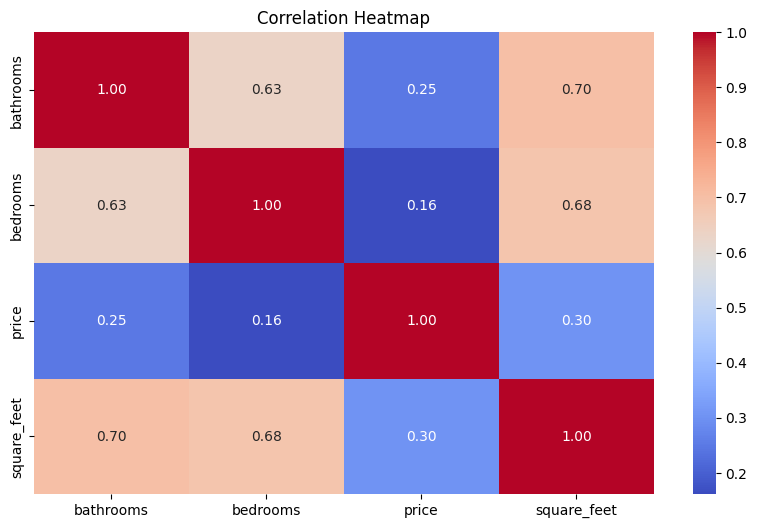

In [ ]:
# Determine correlations
correlation = apartments_df[numerical_cols].corr()

# Set dimensions
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")

# Set title
plt.title("Correlation Heatmap")

# Show plot
plt.show()

Takeaways:

*  We see a strong correlation between square feet, bathrooms, and bedrooms.
*  There does not seem to be a strong correlation with price and any of the numerical features.
*  In particular, bedrooms and price do not have a strong correlation at all. This is something we would like to explore and see how it would confound with our predictions.

### 3.3.2 Covariance Heatmap

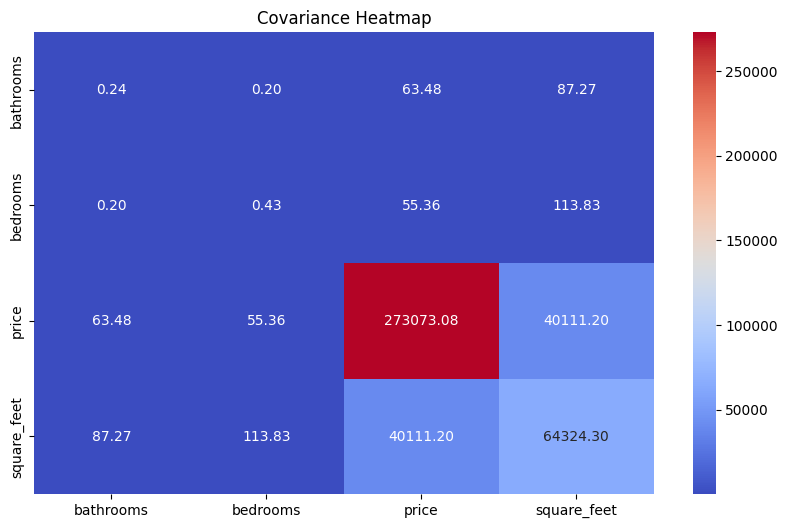

In [ ]:
# Determine covariance
covariance_plots = apartments_df[numerical_cols].cov()

# Set dimensions
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(covariance_plots, annot=True, cmap='coolwarm', fmt=".2f")

# Set title
plt.title("Covariance Heatmap")

# Show plot
plt.show()

Takeaways:

*  There is a high covariance between price and square feet. This means that changing the square feet is going to likely change the price drastically. This is consistent with our reasoning
*  There is not much covariance between bedrooms, bathrooms, and any other features. This means that increasing the number of bedrooms/bathrooms is unlikely to drastically change the price, which is interesting.

# Part 4: Feature Engineering & Preprocessing

Through data pre-processing and EDA, we realized that what we thought were some of our core variables (numerical) were not, and that some of our categorical variables were likely to be core. Therefore, this required us to prepare our catagorical variables for the model to train on; we needed to convert it into some meaningful numerical value. Due to the large amount of amenities and pets listed, we determined that One Hot encoding is optimal. Lastly, we dropped columns that had minimal influence on prediction and also merged features that explained more variance if combined.

## 4.1 New Features

In preparation for modeling, we performed several targeted data cleaning and preprocessing steps based on insights from our exploratory data analysis. To enhance the predictive power of our model, we engineered several new features based on domain knowledge and the EDA. First, we created a `total_rooms` variable by summing the number of bedrooms and bathrooms in each apartment. This feature provides a more comprehensive measure of an apartment’s size and livable space, which is often a stronger driver of price than bedrooms or bathrooms individually. This feature was specifically chosen to capture intuitive, real-world drivers of apartment pricing and to provide richer information for downstream modeling.

In [ ]:
# Create a new feature 'total_rooms' by summing bedrooms and bathrooms
apartments_df['total_rooms'] = apartments_df['bedrooms'] + apartments_df['bathrooms']

# Drop extraneous columns
apartments_df.drop(columns=['bedrooms', 'bathrooms'], inplace=True)

Next, we dropped the `cityname` and `time` columns from the dataset. The `cityname` feature exhibited high cardinality with a large number of unique entries, which can introduce noise and unnecessarily complicate the model without providing substantial predictive benefit. Moreover, `time` appeared to capture the data collection timestamp, which is unlikely to meaningfully influence apartment prices and could introduce temporal bias if not handled carefully. After dropping these irrelevant columns, we focused on encoding categorical variables to make them suitable for modeling. Specifically, we applied one-hot encoding to the `has_photo`, `state`, and `fee` columns using `drop_first=True`. This ensures that we avoid the dummy variable trap and minimize multicollinearity, which is particularly important for linear models. One-hot encoding these features creates clean, interpretable binary indicators, allowing the model to learn meaningful distinctions without inflating feature dimensionality unnecessarily. These preprocessing choices were made to simplify the feature space, reduce noise, and align the dataset with the assumptions of downstream regression models.

In [ ]:
# Drop unnecessary columns that are not useful for modeling
apartments_df = apartments_df.drop(columns=['cityname', 'time'])

# One-hot encode categorical variables: 'has_photo', 'state', and 'fee'
# 'drop_first=True' avoids multicollinearity by dropping the first category
# After encoding, each original category becomes a new binary column (0/1)
# Note that amenities and pets are already One Hot Encoded

apartments_df = pd.get_dummies(apartments_df, columns=['has_photo', 'state', 'fee'], drop_first=True)

Finally, we generated an `is_premium_listing` feature, defined as listings that both include a photo and charge a fee. In rental markets, listings with both characteristics often correspond to higher-end or broker-represented properties, suggesting that such apartments may command a premium price.

In [ ]:
# Create a binary feature 'is_premium_listing' where listings have both a photo and a fee
apartments_df['is_premium_listing'] = (apartments_df['has_photo_Yes'] & apartments_df['fee_Yes']).astype(int)

# Drop extraneous columns
apartments_df.drop(columns=['has_photo_Yes', 'fee_Yes'], inplace=True)

apartments_df.head(5)

price  square_feet  latitude  longitude  amenities_AC  amenities_Alarm  \
0  2195.0          542   33.8520  -118.3759             0                0   
1  1250.0         1500   37.0867   -76.4941             0                0   
2  1395.0         1650   35.8230   -78.6438             0                0   
3  1600.0          820   38.3622  -121.9712             0                0   
4   975.0          624   35.1038  -106.6110             0                0   

   amenities_Basketball  amenities_Cable or Satellite  amenities_Clubhouse  \
0                     0                             0                    0   
1                     0                             0                    0   
2                     0                             0                    0   
3                     0                             0                    0   
4                     0                             0                    0   

   amenities_Dishwasher  amenities_Doorman  amenities_Elevator  \
0                     0                  0                   0   
1                     0                  0                   0   
2                     0                  0                   0   
3                     0                  0                   0   
4                     0                  0                   0   

   amenities_Fireplace  amenities_Garbage Disposal  amenities_Gated  \
0                    0                           0                0   
1                    0                           0                0   
2                    0                           0                0   
3                    0                           0                0   
4                    0                           0                0   

   amenities_Golf  amenities_Gym  amenities_Hot Tub  \
0               0              0                  0   
1               0              0                  0   
2               0              0                  0   
3               0              0                  0   
4               0              0                  0   

   amenities_Internet Access  amenities_Luxury  amenities_Missing  \
0                          0                 0                  1   
1                          0                 0                  1   
2                          0                 0                  1   
3                          0                 0                  1   
4                          0                 0                  1   

   amenities_Parking  amenities_Patio/Deck  amenities_Playground  \
0                  0                     0                     0   
1                  0                     0                     0   
2                  0                     0                     0   
3                  0                     0                     0   
4                  0                     0                     0   

   amenities_Pool  amenities_Refrigerator  amenities_Storage  amenities_TV  \
0               0                       0                  0             0   
1               0                       0                  0             0   
2               0                       0                  0             0   
3               0                       0                  0             0   
4               0                       0                  0             0   

   amenities_Tennis  amenities_View  amenities_Washer Dryer  \
0                 0               0                       0   
1                 0               0                       0   
2                 0               0                       0   
3                 0               0                       0   
4                 0               0                       0   

   amenities_Wood Floors  pets_allowed_Cats  pets_allowed_Dogs  \
0                      0                  1                  0   
1                      0                  1                  1   
2                      0                 

## 4.2 Creating Test & Train Data

Before building and evaluating our predictive models, we first separated our dataset into features and target variables. We defined the feature matrix X as all columns in the dataset except for the target variable price, which was assigned to the target vector y. This ensures a clear distinction between the independent variables used for prediction and the dependent variable we aim to predict. After defining X and y, we split the dataset into training and testing subsets using an 80/20 ratio, where 80% of the data is used to train the models and 20% is reserved for evaluating model performance on unseen data. We set a random seed to ensure that the split is reproducible and results can be consistently compared across model iterations. This approach is essential to avoid overfitting and to obtain an unbiased estimate of how well the model generalizes to new data.



In [ ]:
# Define feature matrix X and target vector y
X = apartments_df.drop(columns=['price'])
y = apartments_df['price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.3 PCA

Before applying PCA, it is essential to standardize the features since PCA is sensitive to the relative scaling of the input variables. In the code below, we standardize the training and test datasets using StandardScaler and then fit PCA to the scaled training data without initially specifying the number of components. This allows us to evaluate the explained variance across all components and make an informed decision on how many to retain.

In [ ]:
# Standardize the training data which is critical before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaling to the test data
X_test_scaled = scaler.transform(X_test)

# Initialize PCA without specifying number of components
pca = PCA()

# Fit PCA on the standardized training data
pca.fit(X_train_scaled)

PCA()

The following code plots the cumulative explained variance as a function of the number of principal components. A horizontal line is drawn at the 80% mark to help visually identify how many components are required to capture at least 80% of the dataset's total variance. This visual diagnostic helps balance dimensionality reduction with information retention.

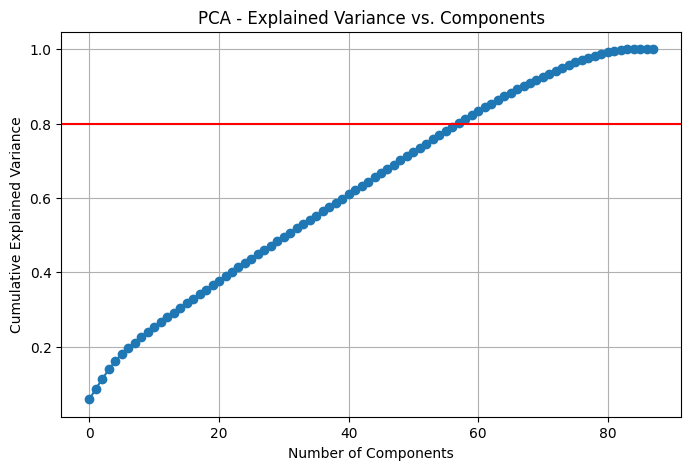

In [ ]:
# Plot cumulative explained variance with 80% threshold line

# Set plot dimensions
plt.figure(figsize=(8,5))

# Create plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

# Set line type
plt.axhline(y = 0.8, color = 'r', linestyle = '-')

# Set axes labels and title
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs. Components')

# Add grid feature
plt.grid(True)

# Show plot
plt.show()

The cumulative explained variance curve shows a smooth, steadily increasing trend. From the graph:

*   The curve reaches 80% explained variance at approximately component 60 (based on visual estimation).
*   Before that point, each added component contributes meaningful additional variance, especially in the early part of the curve.


*   After ~60 components, the curve starts to flatten, indicating diminishing returns -- additional components contribute little incremental variance.

Thus, we re-run our PCA with the number of components set to 60.


In [ ]:
# Re-run PCA with ideal number of components
X_train_scaled = scaler.fit_transform(X_train)
pca_final = PCA(n_components=60)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

With that complete, we now have prepare our data to perform analysis.

# Part 5: Modeling

At this point, we've arrived at a point where we can confidently begin to consider predictive models for our dataset. After cleaning, pre-processing, and performing feature engineering, we're ready to contemplate the relationship between price and several other factors.

## 5.1 Linear Regression

After reducing the dimensionality of the feature space using PCA, the next step is to build a predictive model. We chose Linear Regression because it is a simple, interpretable baseline model that performs well when relationships between variables are approximately linear, especially after removing multicollinearity through PCA. In the code below, we fit a Linear Regression model on the PCA-transformed training data, make predictions on the test set, and evaluate the model’s performance using two key metrics: Mean Squared Error (MSE), which measures the average squared difference between predicted and actual values, and R² Score, which indicates the proportion of variance in the target variable explained by the model. This provides a clear first benchmark for model performance after dimensionality reduction.

In [ ]:
# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Predict on test data
y_pred = lr.predict(X_test_pca)

# R^2 value calculation
lin_reg_test_score = lr.score(X_test_pca, y_test)
lin_reg_train_score = lr.score(X_train_pca, y_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print('Test Set R^2 value: ' + str(lin_reg_test_score))
print('Training Set R^2 value: ' + str(lin_reg_train_score))
print('Mean Squared Error: ' + str(mse))

Test Set R^2 value: 0.4440467858765933
Training Set R^2 value: 0.44648222043004704
Mean Squared Error: 151672.82772615997


The Linear Regression model achieved a Mean Squared Error (MSE) of 151,672.83 and an R² Score of 0.444 on the test set. The MSE indicates the average squared difference between the predicted and actual values is relatively large, suggesting there is still notable error in the predictions. Meanwhile, the R² Score of approximately 0.444 means that the model explains about 44.4% of the variance in the target variable. While this is better than a purely random or mean-based prediction, it also indicates that there is significant unexplained variance, and thus room for improvement. Overall, the model provides a reasonable starting point but may benefit from further refinement, such as using more complex models.

## 5.2 Gradient Boosting Regressor

### 5.2.1 Generic Model

Given the performance of the baseline Linear Regression model, with an R² score of approximately 0.44, it is clear that a significant portion of the variance in the target variable remains unexplained. This suggests that the relationship between the features and the target may be nonlinear or involve complex interactions that a simple linear model cannot capture. A Gradient Boosting Regressor would be a strong next choice because it builds an ensemble of decision trees sequentially, allowing the model to learn nonlinear patterns and subtle feature interactions that Linear Regression inherently misses. Additionally, Gradient Boosting is robust to different feature scales and can achieve high predictive accuracy without assuming a linear relationship between inputs and outputs. As a result, it has the potential to significantly improve model performance compared to the linear baseline.

In [ ]:
# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Fit model on PCA-transformed training data
gbr.fit(X_train_pca, y_train)

# Predict on PCA-transformed test and train data
y_pred_gbr_test = gbr.predict(X_test_pca)
y_pred_gbr_train = gbr.predict(X_train_pca)

# Evaluate model
mse_gbr = mean_squared_error(y_test, y_pred_gbr_test)
r2_train = r2_score(y_train, y_pred_gbr_train)
r2_test = r2_score(y_test, y_pred_gbr_test)

print('Test Set R^2 value: ' + str(r2_train))
print('Training Set R^2 value: ' + str(r2_test))
print('Mean Squared Error: ' + str(mse_gbr))

Test Set R^2 value: 0.5424310811975406
Training Set R^2 value: 0.5295322633834321
Mean Squared Error: 128351.03773808158


The Gradient Boosting Regressor achieved a Mean Squared Error (MSE) of 128351.04 and an R² Score of 0.5424 on the test set, representing a substantial improvement over the baseline Linear Regression model. The lower MSE indicates that the average prediction error has significantly decreased, while the higher R² Score suggests that the model now explains approximately 54.24% of the variance in the target variable. This improvement validates the decision to move beyond a simple linear model, as Gradient Boosting is better equipped to capture the nonlinear relationships and complex feature interactions present in the data. Overall, these results demonstrate that Gradient Boosting provides a much stronger predictive model in this context and confirms its suitability for this task.

### 5.2.2 Hyperparameter Tuning

Hyperparameter optimization is a crucial step to improve model performance beyond the default settings. By using techniques like GridSearchCV, we efficiently explore a subset of possible hyperparameter combinations for the Gradient Boosting Regressor, such as learning rate, tree depth, and number of estimators. This helps the model better capture complex patterns in the data while minimizing overfitting. Optimizing these parameters ensures that the final model is both accurate and generalizable to unseen data, ultimately leading to improved predictive performance over the untuned baseline.

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 6],
    'n_estimators': [100, 200]
}

# Create the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Create the Grid Search Cross-Validation object
grid_search = GridSearchCV(
    gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the Grid Search object to the training data
grid_search.fit(X_train_pca, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

best_params = {
    'max_depth': 3,
    'n_estimators': 200
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 200}


### 5.2.3 Optimal Gradient Boosting Regressor

We now create a new GBR with the optimal parameters.

In [ ]:
# Initialize Gradient Boosting Regressor with best hyperparameters
gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Fit model on PCA-transformed training data
gbr.fit(X_train_pca, y_train)

# Predict on PCA-transformed test data
y_pred_gbr = gbr.predict(X_test_pca)

# Evaluate model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - Mean Squared Error: {mse_gbr:.4f}")
print(f"Gradient Boosting - R² Score: {r2_gbr:.4f}")

Gradient Boosting - Mean Squared Error: 120514.3763
Gradient Boosting - R² Score: 0.5583


After tuning the hyperparameters of the Gradient Boosting Regressor, we observed a slight improvement in the R² score compared to the original model. This suggests that the adjustments—particularly to max_depth and n_estimators—allowed the model to better capture the underlying structure of the data without overfitting. Although the gain is modest, it indicates the value of hyperparameter optimization in enhancing predictive performance. However, we would still like to find a better predictive model.

## 5.3 Random Forest Regressor

The Random Forest Regressor was chosen as a complementary model to Gradient Boosting in order to compare two powerful, tree-based ensemble methods and assess their relative performance on the same dataset. While both models are capable of handling non-linear relationships and feature interactions, they differ in how they build and aggregate decision trees. Gradient Boosting builds trees sequentially, where each new tree attempts to correct the errors of the previous ones, often resulting in higher accuracy but a greater risk of overfitting if not carefully tuned. In contrast, Random Forest builds multiple trees in parallel using bootstrapped samples and aggregates their predictions, making it generally more robust and less sensitive to noise. By training the Random Forest model on the original, non-PCA-transformed data, we preserve the interpretability of the features and leverage the model’s ability to handle multicollinearity natively.

### 5.3.1 Generic Model

In [ ]:
# Fit Random Forest on scaled (non-PCA) features
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Predict and evaluate
y_pred_rfr = rfr.predict(X_test)

mse_rfr = mean_squared_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f"Random Forest - MSE: {mse_rfr:.4f}")
print(f"Random Forest - R² Score: {r2_rfr:.4f}")

Random Forest - MSE: 47475.4043
Random Forest - R² Score: 0.8260


The Random Forest Regressor achieved a Mean Squared Error of just 47475 and an R² Score of over 0.826, indicating strong predictive performance (almost double that of the Gradient Boosting Regressor)! The low MSE reflects a substantial reduction in average prediction error. These results represent a clear improvement over the previous models and demonstrate that Random Forest is highly effective for this regression task.

### 5.3.2 Hyperparameter Tuning

We will once again perform hyperparameter tuning for the model, similar to how we previously did so.

In [ ]:
# Define a basic hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}

# Create the Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)

# Set up Randomized Search with 10 random combinations
random_search = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = random_search.best_params_
print("Best Hyperparameters:", best_params_rf)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


### 5.3.3 Optimal Random Forest Regressor

In [ ]:
# Fit Random Forest using best hyperparameters from RandomizedSearchCV
rfr = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42
)

# Train on the full training data
rfr.fit(X_train, y_train)

# Predict and evaluate
y_pred_rfr = rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f"Random Forest - MSE: {mse_rfr:.4f}")
print(f"Random Forest - R² Score: {r2_rfr:.4f}")

Random Forest - MSE: 38727.0695
Random Forest - R² Score: 0.8580


We again observed a substantial improvement in the performance of our optimized model, proving the power of hyperparameter tuning. Our variance explained increased by 3% while our MSE dropped by over 10,000. Therefore, it is clear that the Random Forest Model is a strong predictor at the fair apartment rental price given the features provided. This makes sense, as the Random Forest employs bagging and averages out its trees, removing noise and thus being strong at predicting the average apartment rental. Because our distribution was normal, this likely means that our Random Forest is great at predicting a typical listing price but not so great at the far ends.

## 5.4 Neural Network

For our last model, we decided to create a neural network. Unlike tree-based models, neural networks learn hierarchical representations through multiple layers, which can be especially effective after dimensionality reduction techniques like PCA. By adjusting the architecture and training parameters, neural networks can generalize well for this sort of regression task.

### 5.4.1 Setting up Capabilities and Tensors

Before training the neural network, the data must be converted into PyTorch tensors and moved to the appropriate device (GPU if available) for efficient computation. The code below handles this preprocessing and confirms the shapes of the resulting tensors to ensure they match the network’s input and output requirements.

In [ ]:
# Sending to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [ ]:
# Creating tensor from test and training data
X_train_tensor = torch.from_numpy(X_train_pca).float().to(device)
X_test_tensor = torch.from_numpy(X_test_pca).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values.reshape(-1, 1)).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values.reshape(-1, 1)).float().to(device)

In [ ]:
# Verifying the number of features and rows within the tensors
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([73580, 60]) torch.Size([18396, 60]) torch.Size([73580, 1]) torch.Size([18396, 1])


### 5.4.2 Creating Architecture

We then needed to create the architecture, consisting of several fully connected layers with ReLU activations to capture nonlinear relationships in the data. After initializing the model, it sets up the mean squared error loss function and the Adam optimizer, which will be used to train the network and minimize prediction error.

In [ ]:
# Defining the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(60, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.fc6 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        return x

In [ ]:
# Defining the loss function and optimizer by which we update the model
net = Net().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

### 5.4.3 Training Network

We are now ready to train the neural netwrok over multiple epochs using mini-batch gradient descent. In each epoch, the model updates its weights based on the training batches, and then evaluates performance on the test set using mean squared error and R² score. The best test MSE is tracked throughout training to monitor improvement.

In [ ]:
# Training the neural network
n_epochs = 50
batch_size = 64
batch_start = torch.arange(0, len(X_train_tensor), batch_size)

best_mse = np.inf
mse_history = []

for epoch in range(n_epochs):
    for start in batch_start:
        X_batch = X_train_tensor[start: start + batch_size].to(device)
        y_batch = y_train_tensor[start: start + batch_size].to(device)

        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        y_pred_test = net(X_test_tensor)
        mse = loss_fn(y_pred_test, y_test_tensor).item()
        r2 = r2_score(y_test_tensor.cpu().numpy(), y_pred_test.cpu().numpy())

    print(f"Epoch {epoch+1}: MSE = {mse:.4f}, R² = {r2:.4f}")
    mse_history.append(mse)

    if mse < best_mse:
        best_mse = mse

Epoch 1: MSE = 113890.5781, R² = 0.5825
Epoch 2: MSE = 112287.7734, R² = 0.5884
Epoch 3: MSE = 111232.1406, R² = 0.5923
Epoch 4: MSE = 109987.8750, R² = 0.5968
Epoch 5: MSE = 109404.4141, R² = 0.5990
Epoch 6: MSE = 108880.6016, R² = 0.6009
Epoch 7: MSE = 108018.9766, R² = 0.6041
Epoch 8: MSE = 107657.7031, R² = 0.6054
Epoch 9: MSE = 106773.3750, R² = 0.6086
Epoch 10: MSE = 106228.5312, R² = 0.6106
Epoch 11: MSE = 105594.8125, R² = 0.6129
Epoch 12: MSE = 105375.6484, R² = 0.6137
Epoch 13: MSE = 104680.7734, R² = 0.6163
Epoch 14: MSE = 104636.9141, R² = 0.6165
Epoch 15: MSE = 104388.3984, R² = 0.6174
Epoch 16: MSE = 104133.8125, R² = 0.6183
Epoch 17: MSE = 103840.3047, R² = 0.6194
Epoch 18: MSE = 104026.7734, R² = 0.6187
Epoch 19: MSE = 103405.6562, R² = 0.6210
Epoch 20: MSE = 103393.1484, R² = 0.6210
Epoch 21: MSE = 103062.6484, R² = 0.6222
Epoch 22: MSE = 102872.8984, R² = 0.6229
Epoch 23: MSE = 102934.7734, R² = 0.6227
Epoch 24: MSE = 102989.5625, R² = 0.6225
Epoch 25: MSE = 102502.20

In [ ]:
print('Best Mean-Squared Error: ' + str(best_mse))

Best Mean-Squared Error: 98997.3984375


The neural network showed consistent improvement over the 50 training epochs, with the R² score increasing from 0.5825 to 0.6371 and the MSE steadily decreasing to a best value of 98,997. This indicates that the model was able to effectively learn patterns in the data and generalize reasonably well to the test set. However, compared to more interpretable models like Gradient Boosting, in the future, neural networks may require more tuning and computational resources to achieve similar or slightly better results.

# Part 6: Interpretation of Models

Although we were now done with training and tuning our models, we would like to evaluate its performance over our actual data visually. This section does not contain extensive comments as it was done mostly for our own sake.

## 6.1 Linear Regression

### 6.1.1 Residual Plot

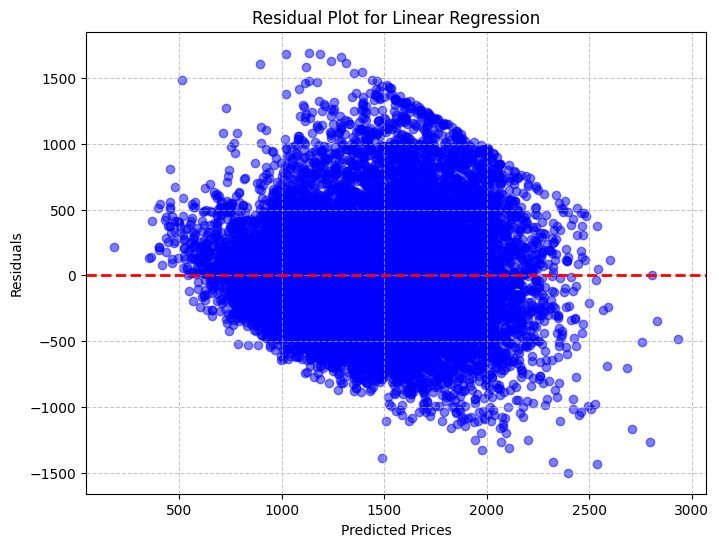

In [ ]:
# Create plot
plt.figure(figsize=(8, 6))

# Calculate residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This residual plot for the linear regression model shows a clear pattern in the residuals, which indicates that the model may not be capturing all the underlying structure in the data. Ideally, residuals should be randomly scattered around zero, but here we see a curved, funnel-like shape. This suggests heteroscedasticity, where the variance of the errors changes with the predicted values, and potential nonlinearity in the data that a linear model fails to account for. As a result, this plot provides evidence that a more flexible model, such as a tree-based method or neural network, might better capture the underlying relationships.

## 6.2 Gradient Boosting Regressor

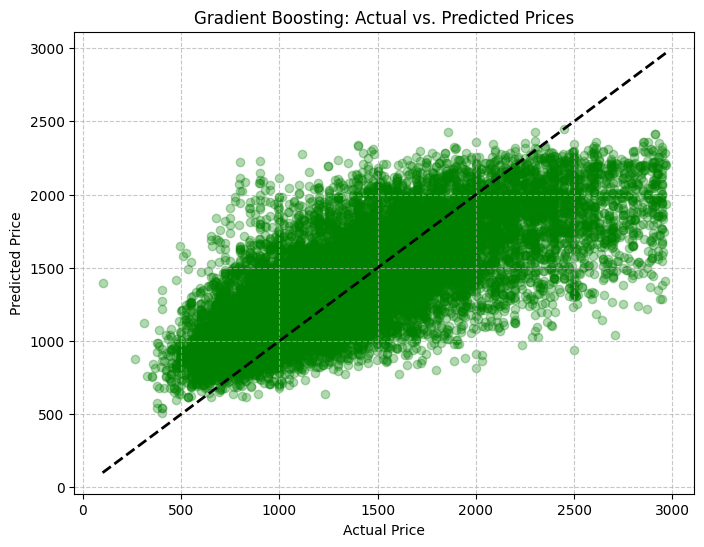

In [ ]:
# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Gradient Boosting: Actual vs. Predicted Prices')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This scatter plot compares the actual vs. predicted prices using the Gradient Boosting model. The points are generally clustered around the diagonal line, indicating a good level of predictive accuracy. However, there's a noticeable tendency to underpredict at higher actual price values, as the predictions flatten out instead of following the upward trend. This suggests that while the model captures much of the structure in the data, it may struggle slightly with extreme values or long-tailed distributions. Overall, though, the results reflect a significantly better fit than the linear model, especially in terms of reduced variance and tighter clustering around the ideal prediction line.

## 6.3 Random Forest Regressor

### 6.3.1 Important Features

To better understand which variables most influenced the predictions made by the Random Forest Regressor, we conducted a feature importance analysis. This approach leverages the model's ability to quantify the relative contribution of each input feature to the overall prediction accuracy. By computing the impurity-based importance scores from the trained model, we identified the top 10 most impactful features. The horizontal bar chart below visualizes these features in descending order of importance, offering insights into which variables played the most significant roles in shaping the model's output.

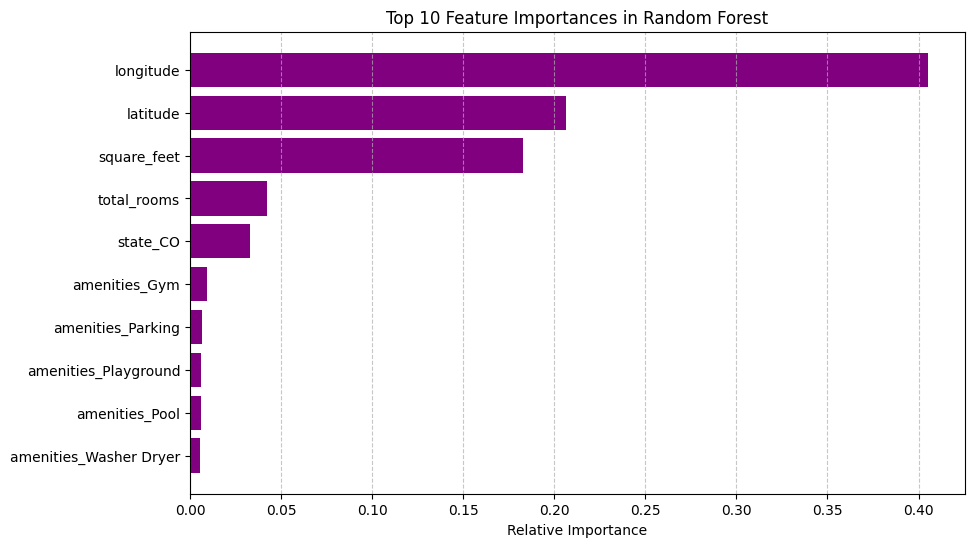

In [ ]:
feature_importances = rfr.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importances)[-10:]  # Top 10 features

# Create plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), feature_importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importances in Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The feature importance chart reveals that location, represented by longitude and latitude, is by far the most influential factor in predicting apartment prices in the U.S. This is consistent with real-world market behavior, where property values are heavily determined by geographic location, proximity to urban centers, desirable neighborhoods, and access to amenities. Together, these two features contribute significantly more than any others, suggesting that where an apartment is located is more predictive of its price than its physical characteristics. Following location, square_feet emerges as the next most important variable, which aligns with expectations since larger apartments generally command higher prices.



Interestingly, the feature state_CO (indicating whether the apartment is located in Colorado) also appears among the top predictors, although with much lower importance than location and size. This suggests that apartments in Colorado may have distinct pricing patterns relative to other states included in the dataset, possibly due to regional market trends, cost of living differences, or demand in urban areas like Denver and Boulder. The fact that a state indicator carries measurable importance highlights that broader geographic or regional effects, beyond specific coordinates, still play a secondary role in pricing.

Other features like bathrooms and total_rooms contribute modestly to the model’s predictions, while amenities such as gyms, parking, and pools have relatively low importance. This indicates that while apartment features and amenities do impact pricing, their influence is minor compared to location and size. Overall, the Random Forest model appears to be prioritizing the most logical predictors, reinforcing confidence in its internal decision-making structure. However, the strong dominance of geographic features suggests that future models might benefit from incorporating even more granular location-based variables, such as neighborhood quality or distance to city centers, to further enhance predictive accuracy.

### 6.3.2 Residual Plot

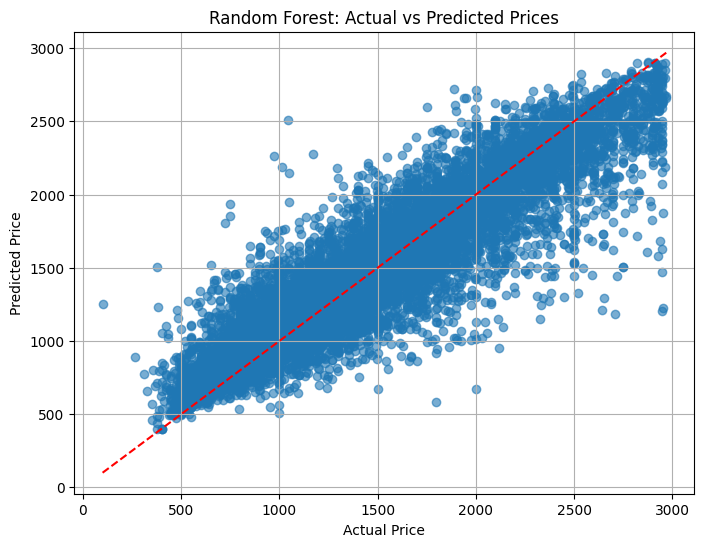

In [ ]:
# Create plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rfr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.grid(True)
plt.show()

This plot shows the actual vs. predicted prices from the Random Forest model. The predictions align fairly well with the diagonal reference line, indicating a strong overall fit. However, there's visible dispersion around higher price values, with the model tending to underpredict expensive items and slightly overpredict lower-priced ones. This spread suggests some bias and a limited ability to fully capture extreme values, though the model still performs much better than linear regression. The tighter clustering compared to more basic models reflects the Random Forest's strength in capturing nonlinear relationships through ensemble learning.

## 6.4 Neural Network

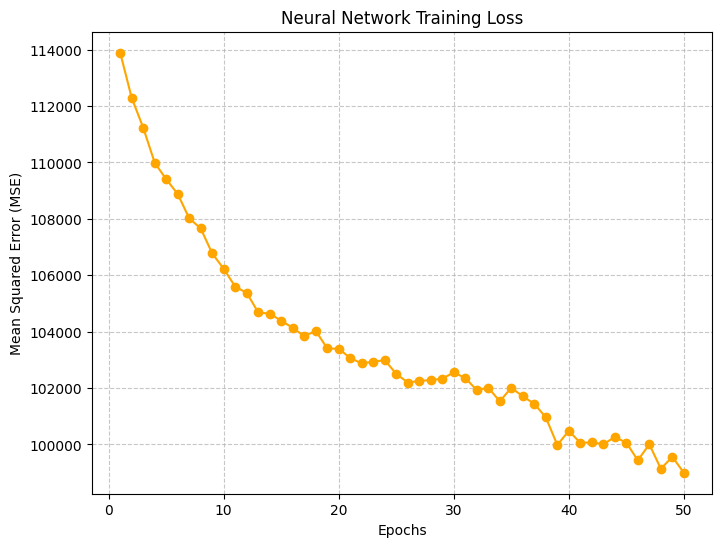

In [ ]:
# Create plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(mse_history)+1), mse_history, marker='o', linestyle='-', color='orange')
plt.title('Neural Network Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This training loss curve shows a steady decline in mean squared error (MSE) over the course of 50 epochs, indicating that the neural network is effectively learning from the data. The sharp drop in the early epochs reflects rapid initial learning, while the slower, more stable decrease toward the end suggests convergence. The absence of any sharp spikes or plateaus implies that the model is not overfitting or getting stuck in local minima, and that the chosen architecture and learning rate are appropriate for this task.

# Part 7: Conclusion

**In summary, here are the main takeaways:**

1.   The factors influencing the apartment rental price listings are roughly what we had thought –– location, square feet, the number of rooms, and ameneities follow suit. Interestingly, the longtitude played far more of an important role than the latitude (twice as influential). This makes sense as the difference of price listings longitudinally, that is, the price of North and South West/East coast don't differ as much as, say, the price of the West coast versus the Rust Belt. To our surprise, Colorado housing played a strong indicator in pricing, likely due to it being an outline amongst the other states surrounding it, playing back into the "gradient effect" highlighted earlier.
2.   Although we One Hot Encoded much of our categorical variables, most of them did not play a strong influence in pridcting price at all. However, logically speaking, amenities should only increase the price listing. For that reason, it is clear that our data is 1. not large enough, and 2. not granual enough to reveal such discrete yet complex relationships between features.
3. The best model was the Random Forest Regressor which produced a test R^2 value of 0.858 and MSE of 38,727.07. We are very pleased with the amount of variance accounted for, however were hoping for a smaller MSE. Unfortunately, due to the sake of time, we were not able to explore more possible tuning methods, as each model took roughly 5 minutes to fit and train.

**In the future, it would be interesting to consider implementing the following modifications:**

1.   We would like to explore more socioeconomic and geospatial features that could influence pricing, such as joining with a US Census dataset consisting of neighborhood factors like average commute time to work, crime rate, percentage of people educated, etc.
2.   We would also like to explore experimenting with our neural network more. Whether it be batch-size or epoch tuning, or changing up our activation functions or optimizer, we believe that it could definitely predict our data much better given the time.
3.   We would also like to improve upon our dataset by including more temporal coverage. The current listing only consisted of 2023, and we would like to explore whether our models could accurately predict rental prices over time, following trends and potentially become a tool for real-world use.
4.   We would like to develop a fair rental pricing classifier. Relatively straightforward, this would involve inputting a given row and then, using our best model, determining whether it is underpriced, fair, or overpriced. It could become a facilitory tool that could save tons of time in the real world. However, we would need for our models to better account for data on the far ends of the distribution.

**Overall Experience + Team Reflection:**

1.   We really enjoyed how this project employed all of the tools we learned throughout this course. Effectively our Magnum Opus, it was a great experience utilizing both heuristic and computational skills to create a predictive model.
2.   We also enjoyed the extensive EDA performed during our analysis. In particular, the Folium Heatmap and Scattermap were our favorites, highlighting trends that we didn't recognize originally. These results also explained much of our model performance.
3.   Tuning the models was definitely challenging and not as streamlined as we had hoped for. It took roughly 5 minutes to train each model (aside from simple Linear Regression), meaning that performing cross-validation for hyperparameter tuning took hours, quite literally. On that end, while we had improved our models slightly, we knew that, given the time, our models could perform much stronger. Interestingly, we now understand why data science is an interative process– how there is always an evident thing to improve. On the other hand, we really experienced the forefront of computation. None of us could recall ever witnessing a computer take more than one second to perform a simple task. This really opened our eyes to how far behind computing power is for our demands for artificial intelligence, and how any breakthrough, such as in quantum computing, may lead to monumental improvements in our models, and thus our society as a whole.
4.   Lastly, we would just like to thank Professor Marcus for instructing the course and the TAs for guiding us through the homeworks and laying the foundation for us to pursue this project.